# Machine Learning Notebook - Matt

In [1]:
%matplotlib inline
import HelperFunctions as hf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load Data

In [2]:
#Load in the raw data
calendar_df = hf.load_calendar_data()
prices_df = hf.load_sell_price_data()
sales_df = hf.load_sales_train_validation_data()

## Clean Data

In [26]:
#Clean the raw data
df = hf.rawToClean(sales_df, calendar_df, prices_df, days=1200, items=1000, dropNAPrices=True)

## Feature Engineering

In [5]:
df = hf.priceDifference(df)

In [6]:
df = hf.rollingPriceDifference(df, windowsize=7)

In [8]:
df = hf.rollingMeanDemandFeature(df, windowSize=7, shift=1)#Mean of previous week
df = hf.rollingMeanDemandFeature(df, windowSize=14, shift=1)
df = hf.rollingMeanDemandFeature(df, windowSize=28, shift=1) #Mean of previous 28 days
df = hf.rollingMeanDemandFeature(df, windowSize=7, shift=7)
df = hf.rollingMeanDemandFeature(df, windowSize=7, shift=28)

In [9]:
df = hf.rollingStdDemandFeature(df, windowSize=7, shift=1)
df = hf.rollingStdDemandFeature(df, windowSize=14, shift=1)
df = hf.rollingStdDemandFeature(df, windowSize=28, shift=1)
df = hf.rollingStdDemandFeature(df, windowSize=7, shift=28)

In [5]:
df = hf.rollingMeanWeekday(df, weeks = 3, shift = 1) #mean of previous 3 weeks (for that particular weekday)

/Users/mattwear/GroupWork/AML/HelperFunctions.py:230: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([data, d])


In [10]:
df = hf.lagFeature(df, var='sold', lag=1) #Amount sold day before
df = hf.lagFeature(df, var='sold', lag=7) #Amount sold a week before
df = hf.lagFeature(df, var='sold', lag=14)
df = hf.lagFeature(df, var='sold', lag=28) #Amount sold 28 days before

In [27]:
df.dropna(inplace=True) #Drop rows with NAs (as result of lagged features)

In [28]:
#product_ids = df.id.copy()
df.drop(['id'], axis=1, inplace=True) #Drop the id column

In [29]:
df.isnull().sum()

d              0
sold           0
wday           0
month          0
year           0
snap_CA        0
snap_TX        0
snap_WI        0
sell_price     0
Cultural       0
National       0
Religious      0
Sporting       0
NoEvent        0
Christmas      0
weekend        0
midweek        0
monfri         0
FOODS_1        0
FOODS_2        0
FOODS_3        0
HOBBIES_1      0
HOBBIES_2      0
HOUSEHOLD_1    0
HOUSEHOLD_2    0
FOODS          0
HOBBIES        0
HOUSEHOLD      0
CA_1           0
CA_2           0
CA_3           0
CA_4           0
TX_1           0
TX_2           0
TX_3           0
WI_1           0
WI_2           0
WI_3           0
CA             0
TX             0
WI             0
dtype: int64

In [18]:
df.shape

(4021657, 41)

In [19]:
df.columns

Index(['d', 'sold', 'wday', 'month', 'year', 'snap_CA', 'snap_TX', 'snap_WI',
       'sell_price', 'Cultural', 'National', 'Religious', 'Sporting',
       'NoEvent', 'Christmas', 'weekend', 'midweek', 'monfri', 'FOODS_1',
       'FOODS_2', 'FOODS_3', 'HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1',
       'HOUSEHOLD_2', 'FOODS', 'HOBBIES', 'HOUSEHOLD', 'CA_1', 'CA_2', 'CA_3',
       'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3', 'CA', 'TX',
       'WI'],
      dtype='object')

# Machine Learning

## Train/Test Split
We also isolate the target variables from the features

In [67]:
#Standardise features
cols_to_norm = ['d','wday','month','year','sell_price','rolling_mean_7_1','rolling_mean_14_1','rolling_mean_28_1','rolling_mean_7_7','rolling_mean_7_28','sold_lag_1',
                'sold_lag_7','sold_lag_14','sold_lag_28','rolling_std_7_1','rolling_std_14_1','rolling_std_28_1',
               'rolling_std_7_28','price_diff']

cols_to_norm = ['d','wday','month','year','sell_price']

df[cols_to_norm] = MinMaxScaler().fit_transform(df[cols_to_norm])

In [69]:
#Isolate features and target variable
y = df.sold.values
X_df = df.drop(['sold'], axis=1)
X = X_df.values

In [22]:
#Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [23]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3217325, 40)
(3217325,)
(804332, 40)
(804332,)


## Linear Regression
The results of fitting a linear regression model on the data and analysing the feature's p-values raises some interesting findings. 
* Amongst the event related features only cultural and xmas are significant. As expected, Xmas is the most influential feature of them all.  
* The LR also confirms our findings in analysis that weekend/monfri/midweek are all significant features for predicting sales volume. 
* CA_4 and CA_3 is the only store that is an insignificant predictor. Perhaps higher population in this area?
* The mean of sold items in the week leading up is the second most influential feature.
* More expensive items sell in lower quantities

In [70]:
mod = sm.OLS(df['sold'], df[X_df.columns])
#mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   sold   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     2566.
Date:                Mon, 29 Mar 2021   Prob (F-statistic):               0.00
Time:                        13:11:38   Log-Likelihood:            -2.2468e+06
No. Observations:              808600   AIC:                         4.494e+06
Df Residuals:                  808568   BIC:                         4.494e+06
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
d              -8.9833      1.224     -7.336      

In [68]:
df.sell_price

2          0.284440
8          0.236868
12         0.221506
13         0.102577
14         0.181368
             ...   
1199995    0.137760
1199996    0.088206
1199997    0.269574
1199998    0.261645
1199999    0.334985
Name: sell_price, Length: 808600, dtype: float64

In [32]:
###Train test split
###Normalise features
###More Data Analysis
###Feature Extraction - average of weekday - exponential averages - Eve Events
###Modelling
###Feature selection - Linear Regression/RandomForests/Lasso/Correlation plots

## Decision Tree Regression - Feature Importance

In [37]:
from sklearn.tree import DecisionTreeRegressor
dc = DecisionTreeRegressor(max_depth=10, random_state=0).fit(X, y)

In [45]:
features = np.array(df.columns)
features = np.delete(features, [1])
feature_imp = pd.DataFrame({'feature': features, 'importance': dc.feature_importances_})
feature_imp = feature_imp.sort_values(by=['importance'], ascending=True).reset_index(drop=True)

In [56]:
feature_imp

,feature,importance
0,Sporting,0.000000
1,Cultural,0.000001
2,HOBBIES_1,0.000005
3,monfri,0.000024
4,NoEvent,0.000029
5,Religious,0.000053
6,midweek,0.000068
7,National,0.000118
8,Christmas,0.000135
9,HOUSEHOLD,0.000442


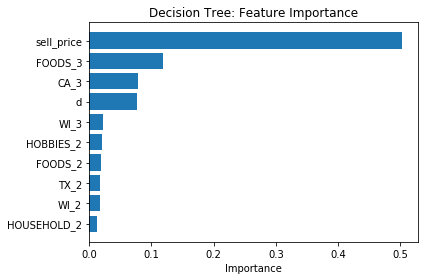

In [61]:
plt.barh(feature_imp.feature[30:], feature_imp.importance[30:])
plt.title('Decision Tree: Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('images/dtfi.png', dpi=500)
plt.show()

## Support Vector Regression
Due to the size of the dataset we can only really use LinearSVR here, since our dataset is too large to make nonlinear SVR's viable

In [20]:
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [21]:
#Initial try at SVR
svm_reg = LinearSVR(epsilon=0.4, C=0.4, random_state=21)
svm_reg.fit(X_train, y_train)

KeyboardInterrupt: 

In [42]:
#Grid Search SVR
parameters = {
    'epsilon': [0.2, 0.4],
    'C': [0.1, 0.4]
}
model = LinearSVR()
clf = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=3)
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0,
                                 fit_intercept=True, intercept_scaling=1.0,
                                 loss='epsilon_insensitive', max_iter=1000,
                                 random_state=None, tol=0.0001, verbose=0),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 0.4], 'epsilon': [0.2, 0.4]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [44]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_epsilon,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,2.958821,0.025446,0.009581,0.000529,0.1,0.2,"{'C': 0.1, 'epsilon': 0.2}",-7.512782,-7.186471,-6.468062,-7.055773,0.436403,3
1,2.504628,0.010741,0.009673,0.001280,0.1,0.4,"{'C': 0.1, 'epsilon': 0.4}",-7.554937,-7.220711,-6.494918,-7.090190,0.442483,4
2,7.982620,0.106887,0.008579,0.000023,0.4,0.2,"{'C': 0.4, 'epsilon': 0.2}",-7.265266,-6.949928,-6.255557,-6.823585,0.421782,1
3,6.143120,0.100372,0.008617,0.000074,0.4,0.4,"{'C': 0.4, 'epsilon': 0.4}",-7.286887,-6.963951,-6.263851,-6.838230,0.427009,2


In [45]:
clf.best_params_

{'C': 0.4, 'epsilon': 0.2}

In [22]:
#Fit model with the best hyper-parameters
svm_reg = LinearSVR(epsilon=0.2, C=0.4, random_state=22)
svm_reg.fit(X_train, y_train)

LinearSVR(C=0.4, dual=True, epsilon=0.2, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=22, tol=0.0001, verbose=0)

In [23]:
#Cross validation scoring metric
cv_score = cross_val_score(svm_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Mean Squared Error CV:", -np.mean(cv_score))

Mean Squared Error CV: 6.787131686368653


In [24]:
preds_train = svm_reg.predict(X_train)
preds_test = svm_reg.predict(X_test)
print(mean_squared_error(y_train, preds_train))
print(mean_squared_error(y_test, preds_test))

6.775330130679082
6.847785314466136


In [25]:
#Coefficient of determination, R2
print(svm_reg.score(X_train, y_train))
print(svm_reg.score(X_test, y_test))

0.5933483357655558
0.5997087616722856


In [28]:
preds_test

array([ 0.21794484, -0.10626046,  6.24359455, ...,  0.02372039,
        0.15304131,  0.29812693])

## Elastic Net
Elastic Net is a linear regression model that incorporates both l1 and l2 regularisation.

In [26]:
from sklearn.linear_model import ElasticNet

Firstly, fit the model with default hyperparameters, alpha=1, l1_ratio=0.5. We can see that the MSE is much higher than for SVR

In [17]:
en = ElasticNet(alpha=1, l1_ratio = 0.5, random_state=101)
en.fit(X_train, y_train)

ElasticNet(alpha=1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=101, selection='cyclic', tol=0.0001, warm_start=False)

In [19]:
#Cross validation scoring metric
cv_score_en = cross_val_score(en, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print("Mean Squared Error CV:", -np.mean(cv_score_en))

Mean Squared Error CV: 16.871055514922304


Cross validated grid search over several potential hyperparameters. The best hyperparameter set found is alpha=0.1, l1_ratio=0.1. l1_ratio being close to zero suggests that the model does not like to suppress any/many features to zero coeff.

In [20]:
#Grid Search SVR
parameters_en = {
    'alpha': [0.1, 1,10],
    'l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9]
}
eNet = ElasticNet()
en_gs = GridSearchCV(eNet, parameters_en, scoring='neg_mean_squared_error', cv=5)
en_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.1, 1, 10],
                         'l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [21]:
en_gs.best_params_

{'alpha': 0.1, 'l1_ratio': 0.1}

Refit the final model using the best hyperparameter set, gives MSE of 15.35.

In [27]:
en = ElasticNet(alpha=0.1, l1_ratio = 0.1, random_state=102)
en.fit(X_train, y_train)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.1,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=102, selection='cyclic', tol=0.0001, warm_start=False)

In [28]:
#Cross validation scoring metric
cv_score_en = cross_val_score(en, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print("Mean Squared Error CV:", -np.mean(cv_score_en))

Mean Squared Error CV: 14.682647916765845
